In [179]:
import matplotlib.pyplot as plt
import numpy
import matplotlib
import matplotlib.colors as colors
from partials import zintegral_fast, restrate_Ia, sigOM0sqinv
from matplotlib import ticker, cm
from astropy.cosmology import FlatLambdaCDM
import scipy.integrate as integrate
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [106]:
#Number of SNe out to redshift
def N_SN_yr(zmax):
    OmegaM0 = 0.28
    cosmo = FlatLambdaCDM(H0=100, Om0=OmegaM0)
    ans = integrate.quad(lambda x: cosmo.differential_comoving_volume(x).value/(1+x), 0, zmax)
    return(ans[0]*restrate_Ia*4*numpy.pi)

In [107]:
# Manips
import pandas as pd
df = pd.DataFrame(index='ZTF Altsched Baseline TAIPAN'.split(),columns = 'emu N zmax date'.split())
df.loc['ZTF-II','emu'] = 0.12
df.loc['ZTF-II','zmax'] = 0.09
df.loc['ZTF-II', 'N'] = 6000
df.loc['ZTF-II','date'] = 2023

df.loc['ZTF-IIb','emu'] = 0.12
df.loc['ZTF-IIb','zmax'] = 0.08
df.loc['ZTF-IIb', 'N'] = 3000
df.loc['ZTF-IIb','date'] = 2023

df.loc['LSST','emu'] = 0.12
df.loc['LSST','zmax'] = 0.08
df.loc['LSST', 'N'] = 3000
df.loc['LSST','date'] = 2031

df.loc['ZTF-I','emu'] = 0.12
df.loc['ZTF-I','zmax'] = 0.08
df.loc['ZTF-I', 'N'] = 800
df.loc['ZTF-I','date'] = 2020

df.loc['SNGrowth (Traditional)','emu']=0.12
df.loc['SNGrowth (Traditional)','zmax']=0.08
df.loc['SNGrowth (Traditional)','N'] = 4000
df.loc['SNGrowth (Traditional)','date'] = 2023

df.loc['SNGrowth (PV optimized)','emu']=0.08
df.loc['SNGrowth (PV optimized)','zmax']=0.08
df.loc['SNGrowth (PV optimized)','N'] = 4000
df.loc['SNGrowth (PV optimized)','date'] = 2023


df.loc['Altsched', 'emu'] = 0.12
df.loc['Altsched', 'N'] = 125000
df.loc['Altsched', 'zmax'] = 0.25
df.loc['Altsched','date'] = 2032
df.loc['Baseline','N'] = 20000
df.loc['Baseline','emu'] = 0.12
df.loc['Baseline','zmax'] = 0.2
df.loc['Baseline','date'] = 2032
df.loc['TAIPAN','emu'] = 0.45
df.loc['TAIPAN','zmax'] = 0.1
df.loc['TAIPAN', 'N'] = 50000
df.loc['TAIPAN','date'] = 2022

In [108]:
def show_marker(name, **kwargs):
   x = numpy.log10(df.loc[name,'N'])
   y = df.loc[name,'emu']
   p = ax.plot(x,y, **{**dict(ls="None", marker="o"),**kwargs})
   return x,y

In [349]:
#ZTF2
skyfrac=0.5
zmax=0.09

#durations = numpy.arange(1,12.1,5)
logdurations = numpy.arange(0.4,1.61,1.2/10)
durations = 10**(logdurations)
sigm_Ias = numpy.arange(0.05,0.501,0.45/10)
X, Y = numpy.meshgrid(numpy.log10(durations*skyarea/4/numpy.pi*N_SN_yr(zmax)), sigm_Ias)
print(X.min(), X.max())

3.668113108593945 4.8681131085939455


In [350]:
var =[]
for sigm_Ia in sigm_Ias:
    v_=[]

    for duration in durations:
        f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax,None,duration,sigm_Ia,restrate_Ia)
        v_.append(numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0])

    var.append(numpy.array(v_)*2*3.14/skyfrac)

In [338]:
#LSST North and South
skyfrac_lsst = 0.75
zmax_lsst=0.2
duration_lsst=10

sigm_Ia_lsst=0.08
f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax,None,duration_lsst,sigm_Ia_lsst,restrate_Ia)
LSST_08 = numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0]

sigm_Ia_lsst=0.12
f00,f11,f10, f02,f12,f22 = zintegral_fast(zmax,None,duration_lsst,sigm_Ia_lsst,restrate_Ia)
LSST_12 = numpy.linalg.inv(numpy.array([[f00,f10,f02],[f10,f11,f12],[f02,f12,f22+sigOM0sqinv]]))[0,0]

LSST_08 = LSST_08*2*3.14/skyfrac_lsst
LSST_12 = LSST_12*2*3.14/skyfrac_lsst

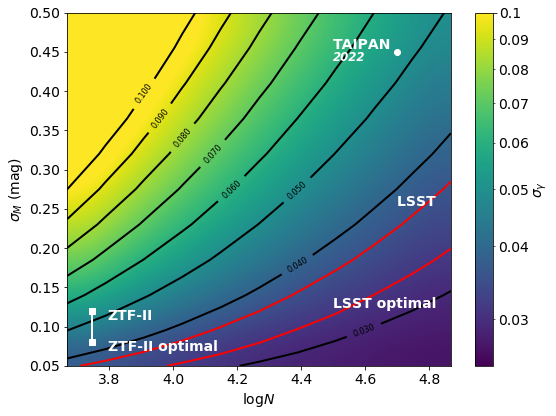

In [351]:
#plots
plt.rcParams["figure.figsize"] = (8,6)
Z = numpy.sqrt(var)
levels = numpy.arange(0.0,.1001,0.01)
fig, ax = plt.subplots()
cs = ax.imshow(Z,norm=colors.LogNorm(),origin='lower',interpolation='bicubic',aspect='auto',
               extent=[X.min(),X.max(), Y.min(), Y.max()],vmin=0.025,vmax=0.1)#, cmap=cm.PuBu_r)
#cs = ax.imshow(Z,origin='lower',interpolation='bicubic',aspect='auto',
#               extent=[X.min(),X.max(), Y.min(), Y.max()])#, cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'$\sigma_\gamma$')
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
#fmt =  ScalarFormatter()
#fmt.set_locs(numpy.arange(0.02,0.1,0.02))
cbar.ax.yaxis.set_minor_formatter(ScalarFormatter())
#cbar.ax.yaxis.get_major_formatter().set_scientific(False)
#cbar.ax.yaxis.get_major_formatter().set_useOffset(False)

cset2 = ax.contour( Z, levels, colors='k',extent=[X.min(), X.max(), Y.min(), Y.max()])
ax.clabel(cset2, inline=True, fontsize=8)

ax.set_xlabel(r'$\log{N}$')
ax.set_ylabel(r'$\sigma_M$ (mag)')

# ZTF-II
name = "ZTF-II"
color = "w"
# x,y = show_marker(name, color=color, marker="s")
logN = numpy.log10(3*skyarea/4/numpy.pi*N_SN_yr(zmax)) # 3-years 

ax.plot([logN,logN],[0.08,0.12],color=color)
p = ax.plot(logN,0.08, **{**dict(ls="None", marker="s",color=color)})
p = ax.plot(logN,0.12, **{**dict(ls="None", marker="s",color=color)})
ax.text(logN+.05,0.12-.015,name, fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")
ax.text(logN+.05,0.08-.015,name+" optimal", fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")
#ax.text(logN+.1,0.1,df.loc[name,'date'], fontdict=dict(color = color ,weight = 'bold'), 
#           va="top", ha="left", style='italic', fontsize="small")

name = "TAIPAN"
color = "w"
x,y = show_marker(name, color=color)
ax.text(x-.2,y,name, fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")
ax.text(x-.2,y,df.loc[name,'date'], fontdict=dict(color = color ,weight = 'bold'), 
           va="top", ha="left", style='italic', fontsize="small")

cset2 = ax.contour( Z, [numpy.sqrt(LSST_08*1.5),numpy.sqrt(LSST_12*1.5)], colors='red',extent=[X.min(), X.max(), Y.min(), Y.max()])
ax.text(4.5,0.12, 'LSST optimal', fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")
ax.text(4.4+.3,0.25, 'LSST ', fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")


#name = 'LSST + North'
#print (numpy.sqrt(LSST_08),numpy.sqrt(LSST_12))
#cset2 = ax.contour( Z, [numpy.sqrt(LSST_08),numpy.sqrt(LSST_12)], colors='red',extent=[X.min(), X.max(), Y.min(), Y.max()])
#ax.text(4.5,0.15, name, fontdict=dict(color = color ,weight = 'bold'), va="bottom", ha="left")
plt.tight_layout()
plt.savefig("surface1.pdf")

In [354]:
import pickle
pkl_file = open('surface.pkl', 'wb')
pickle.dump([var,LSST_08,LSST_12],pkl_file)